In [1]:
import os
import pickle
import torch

import numpy as np
import matplotlib.pyplot as plt

In [2]:
result_path = "/projects/leelab/cl-explainability/results/imagenette2/simclr_x1"
attribution_methods = ["gradient_shap", "int_grad", "vanilla_grad", "random_baseline"]
explanation_methods = ["contrastive", "corpus", "self_weighted"]

explanation_filenames = {
    "self_weighted": "eval_results_removal=blurring_blur_strength=5.0_eval_superpixel_dim=1_eval_foil_size=500.pkl",
    "corpus": "eval_results_corpus_size=100_explicand_size=100_removal=blurring_blur_strength=5.0_eval_superpixel_dim=1_eval_foil_size=500.pkl",
    "contrastive": "eval_results_corpus_size=100_foil_size=500_explicand_size=100_removal=blurring_blur_strength=5.0_eval_superpixel_dim=1_eval_foil_size=500.pkl",
}


attribution_colors = {
    "gradient_shap": "tab:red",
    "int_grad": "tab:orange",
    "vanilla_grad": "tab:blue",
    "random_baseline": "tab:green",
}
explanation_linestyles = {
    "self_weighted": "dotted",
    "corpus": "dashdot",
    "contrastive": "solid",
}


def format_eval_name(name):
    format_map = {
        "similarity": "Similarity to corpus",
        "contrastive_similarity": "Similarity to corpus vs. foil",
        "majority_pred_prob": "Predicted probability of corpus majority",
        "training_set_distance": "L2 distance to training set",
        "explicand_pred_prob": "Predicted probability of explicand",
        "explicand_rep_shift": "Representation shift of explicand",
    }
    return format_map[name]

In [3]:
def plot_results(plot_std: bool = False, plot_abs: bool = False):
    fig, axes = plt.subplots(ncols=6, nrows=2, figsize=(36, 12))
    random_baseline_plotted = False

    for explanation in explanation_methods:
        for attribution in attribution_methods:
            make_plot = True
            if attribution == "random_baseline" and random_baseline_plotted:
                make_plot = False

            if make_plot:
                method = f"{explanation}_{attribution}"
                if attribution == "random_baseline":
                    method_name = "random_baseline"
                else:
                    method_name = method
                if plot_abs:
                    method_name += " (abs)"

                filename = explanation_filenames[explanation]
                if plot_abs:
                    filename = filename.replace(".pkl", "_abs.pkl")
                with open(
                    os.path.join(
                        result_path,
                        method,
                        "123",
                        filename,
                    ),
                    "rb"
                ) as handle:
                    outputs = pickle.load(handle)

                eval_names = outputs[0]["eval_model_names"] + outputs[0]["eval_measure_names"]
                for j, eval_name in enumerate(eval_names):

                    insertion_curves_list = []
                    deletion_curves_list = []
                    insertion_num_features = None
                    deletion_num_features = None

                    for target, results in outputs.items():
                        all_insertion_curve_list = results["model_insertion_curves"] + results["measure_insertion_curves"]
                        all_deletion_curve_list = results["model_deletion_curves"] + results["measure_deletion_curves"]
                        
                        insertion_curves_list.append(all_insertion_curve_list[j])
                        deletion_curves_list.append(all_deletion_curve_list[j])
                        insertion_num_features = results["insertion_num_features"]
                        deletion_num_features = results["deletion_num_features"]
                        formatted_eval_name = format_eval_name(eval_name)

                    insertion_curves = torch.cat(insertion_curves_list)
                    deletion_curves = torch.cat(deletion_curves_list)

                    insertion_curve_mean = insertion_curves.mean(dim=0).cpu().numpy()
                    insertion_curve_std = insertion_curves.std(dim=0).cpu().numpy()
                    deletion_curve_mean = deletion_curves.mean(dim=0).cpu().numpy()
                    deletion_curve_std = deletion_curves.std(dim=0).cpu().numpy()

                    axes[0, j].plot(
                        insertion_num_features,
                        insertion_curve_mean,
                        label=method_name,
                        color=attribution_colors[attribution],
                        linestyle=explanation_linestyles[explanation],
                    )
                    if plot_std:
                        axes[0, j].fill_between(
                            insertion_num_features,
                            insertion_curve_mean - insertion_curve_std,
                            insertion_curve_mean + insertion_curve_std,
                            alpha=0.1,
                        )
                    axes[0, j].set_title(f"Insertion curve: {formatted_eval_name}")
                    axes[0, j].set_xlabel("Number of pixels inserted")
                    axes[0, j].set_ylabel(f"{formatted_eval_name}")
                    axes[0, j].legend()

                    axes[1, j].plot(
                        deletion_num_features,
                        deletion_curve_mean,
                        label=method_name,
                        color=attribution_colors[attribution],
                        linestyle=explanation_linestyles[explanation],
                    )
                    if plot_std:
                        axes[1, j].fill_between(
                            deletion_num_features,
                            deletion_curve_mean - deletion_curve_std,
                            deletion_curve_mean + deletion_curve_std,
                            alpha=0.1,
                        )
                    axes[1, j].set_title(f"Deletion curve: {formatted_eval_name}")
                    axes[1, j].set_xlabel("Number of pixels deleted")
                    axes[1, j].set_ylabel(f"{formatted_eval_name}")
                    axes[1, j].legend()
            else:
                pass
            if attribution == "random_baseline":
                random_baseline_plotted = True
    plt.tight_layout()

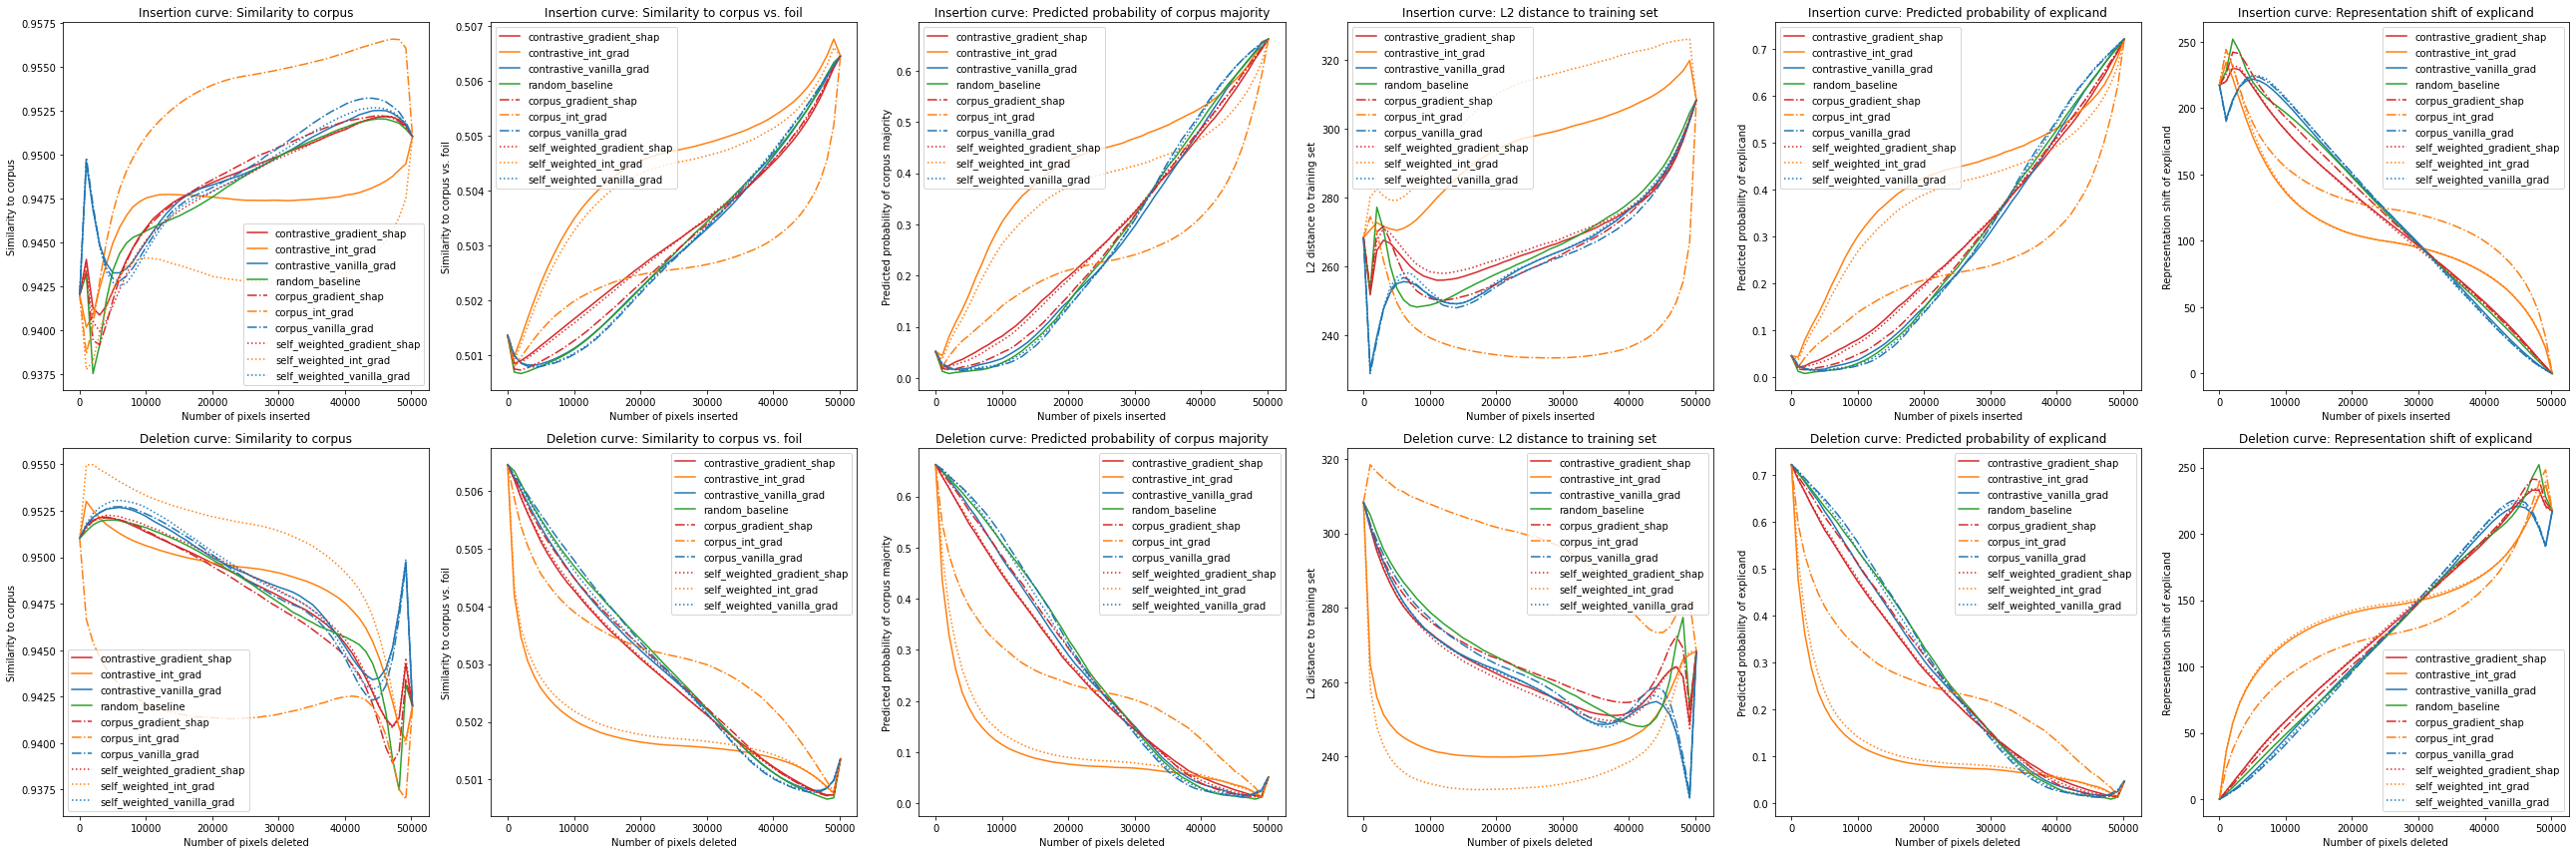

In [4]:
plot_results()

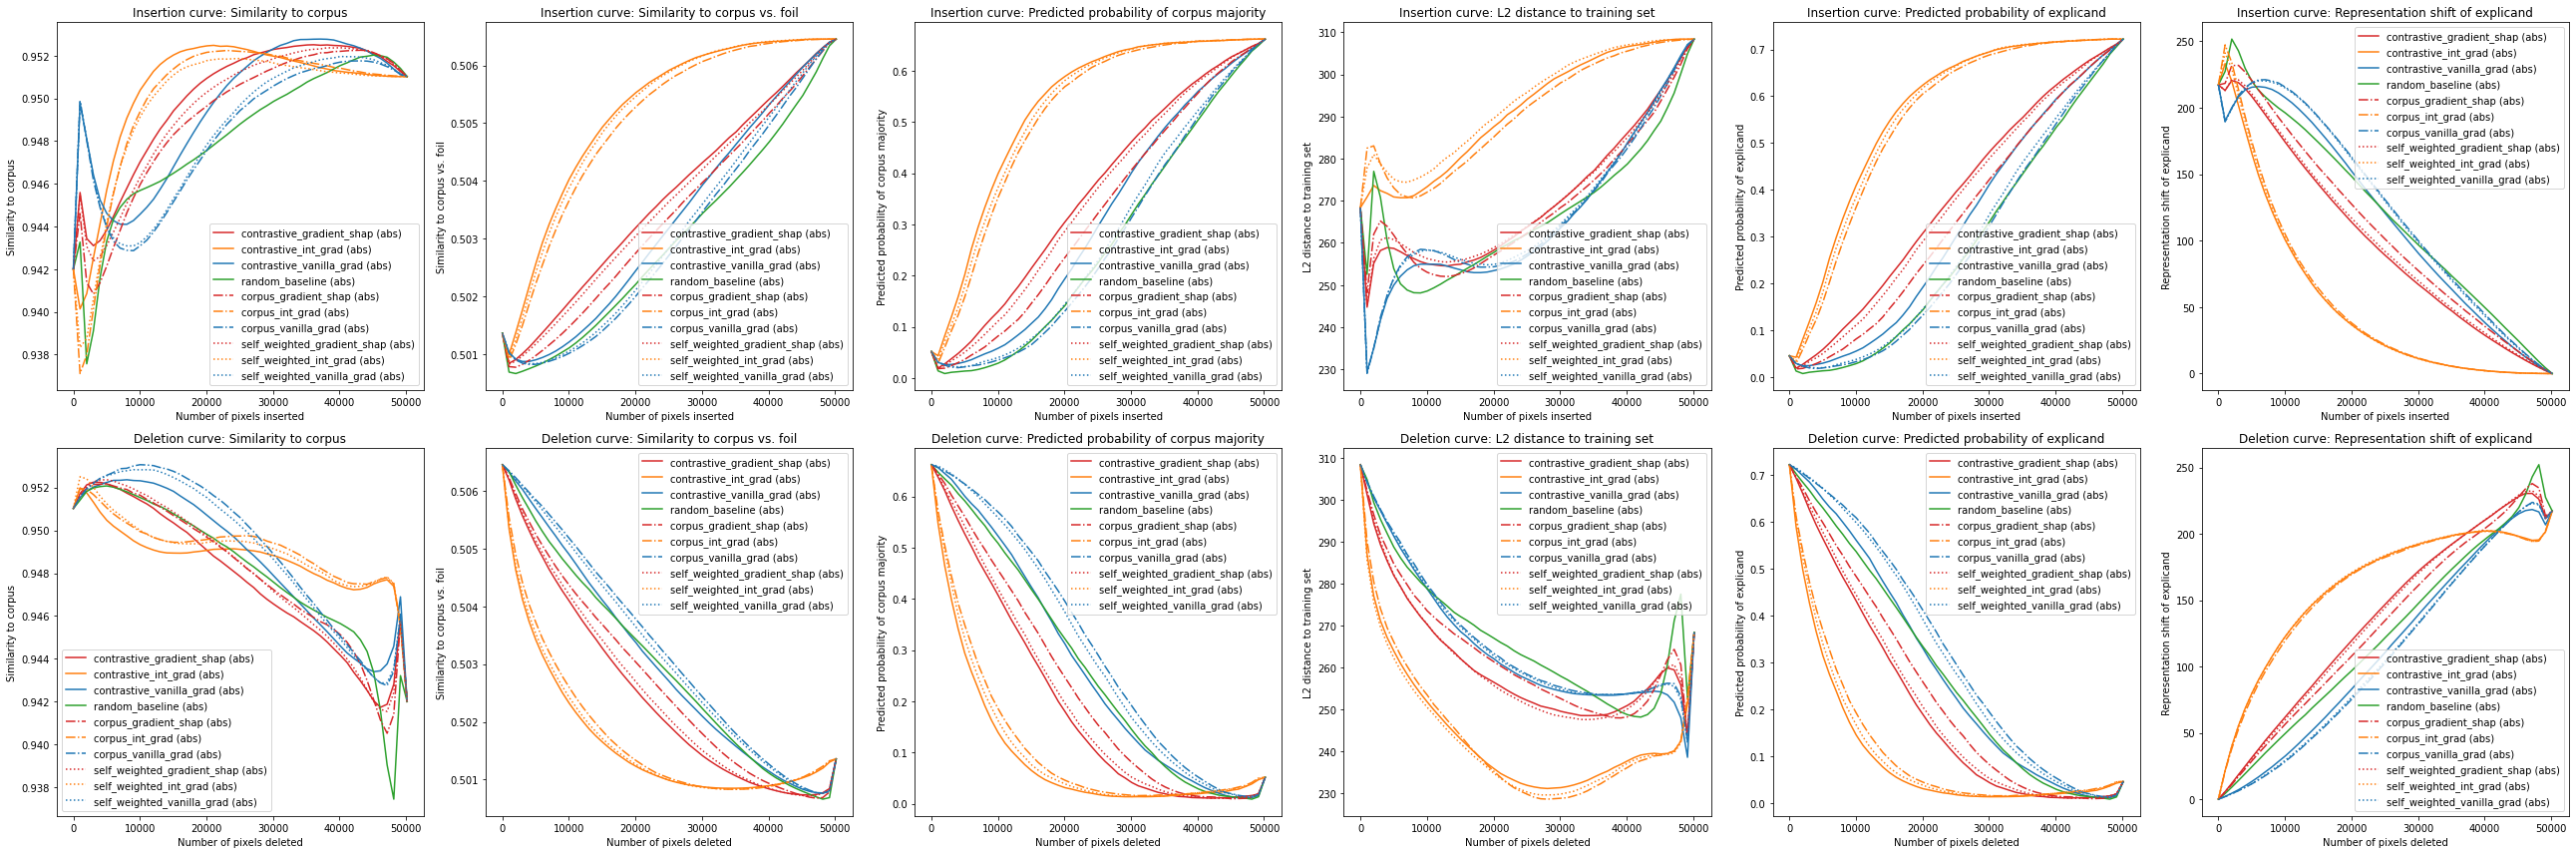

In [5]:
plot_results(plot_abs=True)